In this example, we take the Sanfrancisco 311 Call center data for last 10 years available at :https://data.world/sanfrancisco/mwjb-biik and
use this to predict the Call volume for the next 3 months, and show the Root mean square error (RMSE), 
using different approaches, ie the traditional ARMA, and Deep Learning techniques like Sequence models with LSTM . We establish relation between Call Volume and Average Time to Answer, and Tranferred Calls percentage. Predicting these key parameters can have a lot of impact on efficient Call Center operations.

In [1]:
import pandas
import matplotlib.pyplot as plt
import numpy
import pandas as pd
import math
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from pandas.plotting import scatter_matrix

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDRegressor
from keras.models import Sequential
from keras.layers import Dense   
from keras import optimizers

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np
from pandas import DataFrame
from pandas import concat
from keras.models import load_model
from keras import optimizers
from matplotlib import pyplot
from math import sqrt
from keras import optimizers

numpy.random.seed(7)

# load the dataset
dataframe = pandas.read_csv('C:/users/hackuser1/Hackathon18/311_call_metrics.csv', header=0, engine='python', skipfooter=3)
dataframe['month'] = pd.to_datetime(dataframe.month)
dataframe=dataframe.sort_values(by='month',ascending=True)
dataframe.head()
regr_dataset = dataframe.copy()

Using TensorFlow backend.


Next we sort the data based on the month and plot the data, to observe the trends. Since we are now going to 
predict the Call Volume of next 3 months based on historical data of Call Volume, we take the month and 
Call volume in our dataset

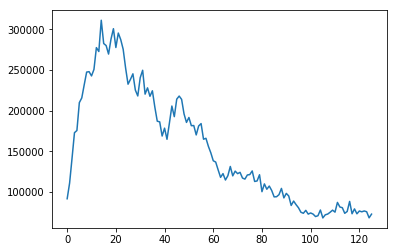

In [2]:
dataframe = dataframe.iloc[:,0:2]
dataset = dataframe.values[:,1:2]
dataset = dataset.astype('float32')

plt.plot(dataset)
plt.show()

Next we Scale the dataset using MinMaxScaler in a range of 0 to 1

In [3]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

We split the train and test data. We have 120 values, worth of 10 years of data, on a monthly basis. We take
20 values as test data, and remaining as train data. Since this is time series data, we take the first 106 values
as train data and next 20 values as test data

In [4]:
train_size = int(len(dataset)) - 20
test_size = 20
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

106 20


The next part is the most important step in creating the train data for a Supervised Learning problem.
We shift the data with a lookback of 10 time steps and use this data to predict the value of the Call volume 
at the next time step.

In [5]:
def createSupervisedTrainingSet(dataset,lookback):

    df = DataFrame()
    x = dataset
    
    len_series = x.shape[0]

    df['t'] = [x[i] for i in range(x.shape[0])]
    #create x values at time t
    x=df['t'].values
    
    cols=list()
    #create dataframe series for t+1,t+2,t+3, to be used as y values, during Supervised Learning
    #lookback = 10, means 10 values of TimeSeries (x) are used to predict the value at time t+1,t+2,t+3 (y)

    df['t+1'] = df['t'].shift(-lookback)
    cols.append(df['t+1'])
    df['t+2'] = df['t'].shift(-(lookback+1))
    cols.append(df['t+2'])
    df['t+3'] = df['t'].shift(-(lookback+2))
    cols.append(df['t+3'])
    agg = concat(cols,axis=1)
    y=agg.values

    x = x.reshape(x.shape[0],1)

    len_X = len_series-lookback-2
    X=np.zeros((len_X,lookback,1))
    Y=np.zeros((len_X,3))
 
    for i in range(len_X):
        X[i] = x[i:i+10]
        Y[i] = y[i]

    return X,Y
 

look_back = 10
trainX, trainY = createSupervisedTrainingSet(train, look_back)
testX,testY = createSupervisedTrainingSet(test, look_back)

In [64]:
testY=testY.reshape(testY.shape[0],testY.shape[1])
trainY=trainY.reshape(trainY.shape[0],trainY.shape[1])
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)


(94, 10, 1)
(94, 3)
(8, 10, 1)
(8, 3)


In [44]:
#Check the sample train X and train Y, and match with original time series data
print1 = trainY[93,:].reshape(1,-1)
print("Train X at index 93")
print(np.around(scaler.inverse_transform(trainX[93,:,:])))
print("Train Y at index 93")
print(np.around(scaler.inverse_transform(print1)))
print("Actual Data")
print(np.around(scaler.inverse_transform(dataset[93:106])))        
#We used a lookback value of 10
#As can be seen the 10 values of Time Series (Call Volume) from index 93 are being used as X to 
#predict the 3 values coming next (t+1,t+2,t+3)

Train X at index 93
[[ 89074.]
 [ 84685.]
 [ 80836.]
 [ 75324.]
 [ 74064.]
 [ 77644.]
 [ 73027.]
 [ 74445.]
 [ 73047.]
 [ 70038.]]
Train Y at index 93
[[ 71042.  78059.  68355.]]
Actual Data
[[ 89074.]
 [ 84685.]
 [ 80836.]
 [ 75324.]
 [ 74064.]
 [ 77644.]
 [ 73027.]
 [ 74445.]
 [ 73047.]
 [ 70038.]
 [ 71042.]
 [ 78059.]
 [ 68355.]]


Use a Deep Learning technique with one hidden layer of 20 LSTM cells, outputting into 3 values, ie the predictions
at time t+1,t+2,t+3. Input layer being 10 by 1 in size, for the 10 prior values of time series.

In [14]:
model = Sequential()
model.add(LSTM(20, input_shape=(look_back, 1)))
model.add(Dense(3))
myOptimizer = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=0.01, decay=0.0)
model.compile(loss='mean_squared_error', optimizer=myOptimizer)
history = model.fit(trainX, trainY, epochs=200,  validation_data=(testX,testY), batch_size=5, verbose=2)

Train on 94 samples, validate on 8 samples
Epoch 1/200
 - 1s - loss: 0.1313 - val_loss: 0.0738
Epoch 2/200
 - 0s - loss: 0.0520 - val_loss: 0.0728
Epoch 3/200
 - 0s - loss: 0.0335 - val_loss: 0.0299
Epoch 4/200
 - 0s - loss: 0.0240 - val_loss: 0.0143
Epoch 5/200
 - 0s - loss: 0.0142 - val_loss: 0.0027
Epoch 6/200
 - 0s - loss: 0.0097 - val_loss: 0.0011
Epoch 7/200
 - 0s - loss: 0.0086 - val_loss: 0.0012
Epoch 8/200
 - 0s - loss: 0.0084 - val_loss: 6.7697e-04
Epoch 9/200
 - 0s - loss: 0.0081 - val_loss: 0.0011
Epoch 10/200
 - 0s - loss: 0.0083 - val_loss: 0.0015
Epoch 11/200
 - 0s - loss: 0.0087 - val_loss: 2.2917e-04
Epoch 12/200
 - 0s - loss: 0.0081 - val_loss: 4.3420e-04
Epoch 13/200
 - 0s - loss: 0.0078 - val_loss: 0.0029
Epoch 14/200
 - 0s - loss: 0.0076 - val_loss: 3.8177e-04
Epoch 15/200
 - 0s - loss: 0.0083 - val_loss: 3.4147e-04
Epoch 16/200
 - 0s - loss: 0.0075 - val_loss: 7.0242e-04
Epoch 17/200
 - 0s - loss: 0.0073 - val_loss: 0.0010
Epoch 18/200
 - 0s - loss: 0.0069 - val_l

Epoch 145/200
 - 0s - loss: 0.0043 - val_loss: 3.5593e-04
Epoch 146/200
 - 0s - loss: 0.0040 - val_loss: 4.6143e-04
Epoch 147/200
 - 0s - loss: 0.0046 - val_loss: 4.0758e-04
Epoch 148/200
 - 0s - loss: 0.0042 - val_loss: 5.1156e-04
Epoch 149/200
 - 0s - loss: 0.0043 - val_loss: 4.8403e-04
Epoch 150/200
 - 0s - loss: 0.0039 - val_loss: 3.4397e-04
Epoch 151/200
 - 0s - loss: 0.0042 - val_loss: 5.1988e-04
Epoch 152/200
 - 0s - loss: 0.0045 - val_loss: 5.6208e-04
Epoch 153/200
 - 0s - loss: 0.0044 - val_loss: 6.0086e-04
Epoch 154/200
 - 0s - loss: 0.0043 - val_loss: 7.4540e-04
Epoch 155/200
 - 0s - loss: 0.0041 - val_loss: 4.4009e-04
Epoch 156/200
 - 0s - loss: 0.0044 - val_loss: 4.7190e-04
Epoch 157/200
 - 0s - loss: 0.0040 - val_loss: 3.9744e-04
Epoch 158/200
 - 0s - loss: 0.0040 - val_loss: 3.4827e-04
Epoch 159/200
 - 0s - loss: 0.0041 - val_loss: 4.3645e-04
Epoch 160/200
 - 0s - loss: 0.0046 - val_loss: 5.0181e-04
Epoch 161/200
 - 0s - loss: 0.0043 - val_loss: 6.7173e-04
Epoch 162/200


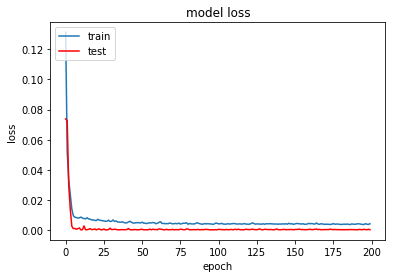

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], color=  'red')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Once the model is trained, use it to make a prediction on the test data

In [16]:
testPredict = model.predict(testX)
predictUnscaled = np.around(scaler.inverse_transform(testPredict))
testYUnscaled = np.around(scaler.inverse_transform(testY))
#print the actual and predicted values at t+3
print("Actual values of Call Volume")
print(testYUnscaled[:,2])
print("Predicted values of Call Volume")
print(predictUnscaled[:,2])

Actual values of Call Volume
[ 79410.  73427.  76847.  75870.  76892.  75949.  68468.  72996.]
Predicted values of Call Volume
[ 71566.  78282.  72974.  73524.  70346.  70681.  70506.  71066.]


In [ ]:
Plot the predicted and actual values at time t+1,t+2,t+3

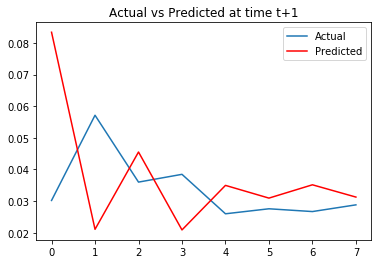

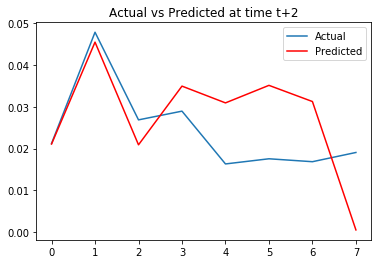

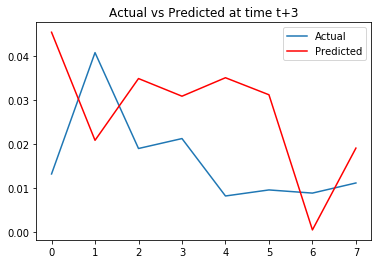

In [17]:
pyplot.plot(testPredict[:,0])
pyplot.plot(testY[:,0],color='red')
pyplot.legend(['Actual','Predicted'])
pyplot.title('Actual vs Predicted at time t+1')
pyplot.show()

pyplot.plot(testPredict[:,1])
pyplot.plot(testY[:,1],color='red')
pyplot.legend(['Actual','Predicted'])
pyplot.title('Actual vs Predicted at time t+2')
pyplot.show()

pyplot.plot(testPredict[:,2])
pyplot.plot(testY[:,2],color='red')
pyplot.legend(['Actual','Predicted'])
pyplot.title('Actual vs Predicted at time t+3')
pyplot.show()

Evaluate the RMSE values at t+1,t+2,t+3 to compare with other approaches, and select the best approach

In [18]:
def evaluate_forecasts(actuals, forecasts, n_seq):
    	for i in range(n_seq):
            actual = actuals[:,i]
            predicted = forecasts[:,i]
            rmse = sqrt(mean_squared_error(actual, predicted))
            print('t+%d RMSE: %f' % ((i+1), rmse))
        
evaluate_forecasts(testYUnscaled, predictUnscaled,3)

t+1 RMSE: 5886.232103
t+2 RMSE: 2919.462772
t+3 RMSE: 4796.919454


It can be clearly seen, the RMSE values are much better than traditional ARMA models, and hence Deep Learning 
is useful in this scenario to predict the Call Volume at time t+1,t+2 and t+3

We try to improve the DeepLearning approach further by using Grid Search of Neural Network parameters
using sklearn wrapper for Keras, KerasRegressor, and GridSearchCV.
First, we tune best batch size and number of epochs

In [6]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
# Function to create model, required for KerasRegressor
def create_model():
    model = Sequential()
    model.add(LSTM(20, input_shape=(look_back, 1)))
    model.add(Dense(3))
    myOptimizer = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=0.01, decay=0.0)
    model.compile(loss='mean_squared_error', optimizer=myOptimizer,metrics=['mse'])
    return model


In [7]:
# create model
model = KerasRegressor(build_fn=create_model, verbose=0)
# define the grid search parameters
batch_size = [5,10,20]
epochs = [50, 100 , 200]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(trainX, trainY)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -0.005838 using {'batch_size': 5, 'epochs': 200}


We find batch size : 5 and epochs : 200 gives best results
Next, we tune the parameters of the optimization algorithm

In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
def create_model(learn_rate=0.01, beta1=0.9, beta2=0.999):
    model = Sequential()
    model.add(LSTM(20, input_shape=(look_back, 1)))
    model.add(Dense(3))
    myOptimizer = optimizers.Adam(lr=learn_rate, beta_1=beta1, beta_2=beta2, epsilon=0.01, decay=0.0)
    model.compile(loss='mean_squared_error', optimizer=myOptimizer,metrics=['mse'])
    return model
# create model
model = KerasRegressor(build_fn=create_model, epochs=200, batch_size=5, verbose=0)
# define the grid search parameters
learn_rate = [0.001, 0.01, 0.1]
beta1 = [0.85, 0.9, 0.95]
beta2 = [0.990,0.995,0.999]
param_grid = dict(learn_rate=learn_rate, beta1=beta1, beta2=beta2)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(trainX, trainY)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

We find the values beta1:0.9, beta2:0.999 and learn_rate:0.1 as optimum
Next we attempt to fine-tune number of neurons and also LSTM State in the model.

In [10]:
model = Sequential()
model.add(LSTM(30, input_shape=(look_back, 1),stateful=False))
model.add(Dense(3))
myOptimizer = optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=0.01, decay=0.0)
model.compile(loss='mean_squared_error', optimizer=myOptimizer,metrics=['mse'])
history = model.fit(trainX, trainY, epochs=200,  validation_data=(testX,testY), batch_size=5, verbose=2)
#mse = 0.0061 with 30 neurons
#mse = 0.0042 with 20 neurons

Train on 94 samples, validate on 8 samples
Epoch 1/200
 - 0s - loss: 0.0812 - mean_squared_error: 0.0812 - val_loss: 0.0119 - val_mean_squared_error: 0.0119
Epoch 2/200
 - 0s - loss: 0.0245 - mean_squared_error: 0.0245 - val_loss: 0.0062 - val_mean_squared_error: 0.0062
Epoch 3/200
 - 0s - loss: 0.0084 - mean_squared_error: 0.0084 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 4/200
 - 0s - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 5/200
 - 0s - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 3.4983e-04 - val_mean_squared_error: 3.4983e-04
Epoch 6/200
 - 0s - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 9.2151e-04 - val_mean_squared_error: 9.2151e-04
Epoch 7/200
 - 0s - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0056 - val_mean_squared_error: 0.0056
Epoch 8/200
 - 0s - loss: 0.0073 - mean_squared_error: 0.0073 - val_loss: 6.1277e-04 - val_mean_squared_error: 6.1277e-04
Epoch 9/200
 - 0s - l

Epoch 70/200
 - 0s - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 71/200
 - 0s - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 4.9592e-04 - val_mean_squared_error: 4.9592e-04
Epoch 72/200
 - 0s - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 73/200
 - 0s - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 74/200
 - 0s - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 75/200
 - 0s - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 76/200
 - 0s - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 77/200
 - 0s - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 8.8240e-04 - val_mean_squared_error: 8.8240e-04
Epoch 78/200
 - 0s - loss: 0.0053 - mean_squared_error: 0.0053 -

Epoch 139/200
 - 0s - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 7.2750e-04 - val_mean_squared_error: 7.2750e-04
Epoch 140/200
 - 0s - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 141/200
 - 0s - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 8.1569e-04 - val_mean_squared_error: 8.1569e-04
Epoch 142/200
 - 0s - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 143/200
 - 0s - loss: 0.0072 - mean_squared_error: 0.0072 - val_loss: 6.4203e-04 - val_mean_squared_error: 6.4203e-04
Epoch 144/200
 - 0s - loss: 0.0070 - mean_squared_error: 0.0070 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 145/200
 - 0s - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 146/200
 - 0s - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 8.7686e-04 - val_mean_squared_error: 8.7686e-04
Epoch 147/200
 - 0s - loss: 0.0054 - mea

This shows 20 neurons in hidden layer gives best results, and we select this. 
Now we check with LSTM stateful = True and compare the results

In [6]:
model = Sequential()
model.add(LSTM(20, batch_input_shape=(2,look_back, 1),stateful=True))
model.add(Dense(3))
myOptimizer = optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=0.01, decay=0.0)
model.compile(loss='mean_squared_error', optimizer=myOptimizer,metrics=['mse'])
history = model.fit(trainX, trainY, epochs=200,  validation_data=(testX,testY), batch_size=2, verbose=2)


Train on 94 samples, validate on 8 samples
Epoch 1/200
 - 2s - loss: 0.0457 - mean_squared_error: 0.0457 - val_loss: 0.0206 - val_mean_squared_error: 0.0206
Epoch 2/200
 - 0s - loss: 0.0155 - mean_squared_error: 0.0155 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 3/200
 - 0s - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 4/200
 - 0s - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 6.9517e-04 - val_mean_squared_error: 6.9517e-04
Epoch 5/200
 - 0s - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 6/200
 - 0s - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 7/200
 - 0s - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 5.5608e-04 - val_mean_squared_error: 5.5608e-04
Epoch 8/200
 - 0s - loss: 0.0074 - mean_squared_error: 0.0074 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 9/200
 - 0s - loss: 0.0

 - 0s - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 72/200
 - 0s - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 73/200
 - 0s - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 8.7938e-04 - val_mean_squared_error: 8.7938e-04
Epoch 74/200
 - 0s - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 75/200
 - 0s - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 76/200
 - 0s - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 77/200
 - 0s - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 78/200
 - 0s - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 8.9030e-04 - val_mean_squared_error: 8.9030e-04
Epoch 79/200
 - 0s - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 8.

Epoch 142/200
 - 0s - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0065 - val_mean_squared_error: 0.0065
Epoch 143/200
 - 0s - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 144/200
 - 0s - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 5.8025e-04 - val_mean_squared_error: 5.8025e-04
Epoch 145/200
 - 0s - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 146/200
 - 0s - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 147/200
 - 0s - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 148/200
 - 0s - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 4.8867e-04 - val_mean_squared_error: 4.8867e-04
Epoch 149/200
 - 0s - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 150/200
 - 0s - loss: 0.0053 - mean_squared_error:

#we find mse = 0.0053
So we conclude 20 neurons, with stateful = False is the best configuration.

In [6]:
#final model
model = Sequential()
model.add(LSTM(20, input_shape=(look_back, 1),stateful=False))
model.add(Dense(3))
myOptimizer = optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=0.01, decay=0.0)
model.compile(loss='mean_squared_error', optimizer=myOptimizer,metrics=['mse'] )
history = model.fit(trainX, trainY, epochs=200,  validation_data=(testX,testY), batch_size=5, verbose=2)

Train on 94 samples, validate on 8 samples
Epoch 1/200
 - 1s - loss: 0.0907 - mean_squared_error: 0.0907 - val_loss: 0.0377 - val_mean_squared_error: 0.0377
Epoch 2/200
 - 0s - loss: 0.0174 - mean_squared_error: 0.0174 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 3/200
 - 0s - loss: 0.0097 - mean_squared_error: 0.0097 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 4/200
 - 0s - loss: 0.0076 - mean_squared_error: 0.0076 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 5/200
 - 0s - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 3.9313e-04 - val_mean_squared_error: 3.9313e-04
Epoch 6/200
 - 0s - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 7/200
 - 0s - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 5.7075e-04 - val_mean_squared_error: 5.7075e-04
Epoch 8/200
 - 0s - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 9/200
 - 0s - loss: 0.0

Epoch 70/200
 - 0s - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 71/200
 - 0s - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 72/200
 - 0s - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 8.8035e-04 - val_mean_squared_error: 8.8035e-04
Epoch 73/200
 - 0s - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 7.3547e-04 - val_mean_squared_error: 7.3547e-04
Epoch 74/200
 - 0s - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 4.8648e-04 - val_mean_squared_error: 4.8648e-04
Epoch 75/200
 - 0s - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 76/200
 - 0s - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 4.8719e-04 - val_mean_squared_error: 4.8719e-04
Epoch 77/200
 - 0s - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 78/200
 - 0s - loss: 0.0051 - mean_squared

 - 0s - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 8.5183e-04 - val_mean_squared_error: 8.5183e-04
Epoch 140/200
 - 0s - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 141/200
 - 0s - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 142/200
 - 0s - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 9.4111e-04 - val_mean_squared_error: 9.4111e-04
Epoch 143/200
 - 0s - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 144/200
 - 0s - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 145/200
 - 0s - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 146/200
 - 0s - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 147/200
 - 0s - loss: 0.0051 - mean_squared_error: 0.0051 - val_

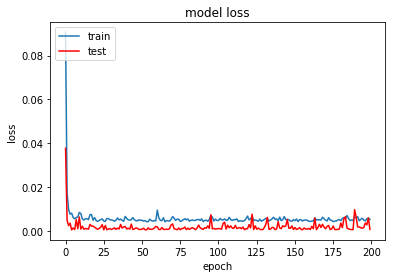

In [7]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], color=  'red')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [9]:
testPredict = model.predict(testX)
print(testPredict.shape)
predictUnscaled = np.around(scaler.inverse_transform(testPredict))
testYUnscaled = np.around(scaler.inverse_transform(testY))
#print the actual and predicted values at t+3
print("Actual values of Call Volume")
print(testYUnscaled[:,2])
print("Predicted values of Call Volume")
print(predictUnscaled[:,2])

(8, 3)
Actual values of Call Volume
[ 79410.  73427.  76847.  75870.  76892.  75949.  68468.  72996.]
Predicted values of Call Volume
[ 71510.  80305.  73490.  74163.  70867.  71865.  71944.  72691.]


In [13]:
evaluate_forecasts(testYUnscaled, predictUnscaled,3)

t+1 RMSE: 7980.336263
t+2 RMSE: 4846.207770
t+3 RMSE: 4861.268662


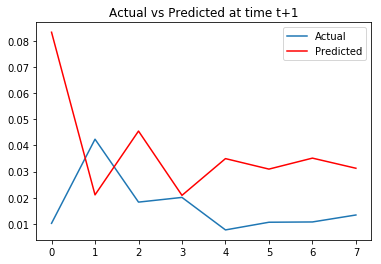

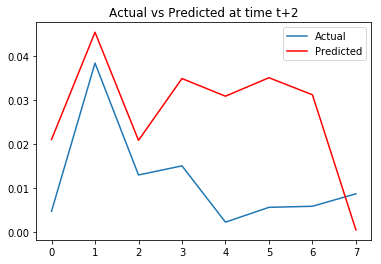

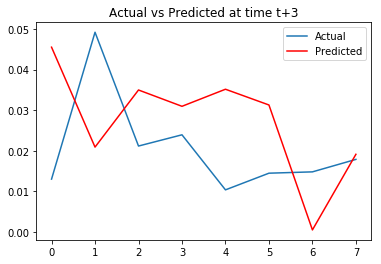

In [10]:
pyplot.plot(testPredict[:,0])
pyplot.plot(testY[:,0],color='red')
pyplot.legend(['Actual','Predicted'])
pyplot.title('Actual vs Predicted at time t+1')
pyplot.show()

pyplot.plot(testPredict[:,1])
pyplot.plot(testY[:,1],color='red')
pyplot.legend(['Actual','Predicted'])
pyplot.title('Actual vs Predicted at time t+2')
pyplot.show()

pyplot.plot(testPredict[:,2])
pyplot.plot(testY[:,2],color='red')
pyplot.legend(['Actual','Predicted'])
pyplot.title('Actual vs Predicted at time t+3')
pyplot.show()

We now do the regression analysis between Calls answered and transferred calls percentage

In [173]:
regr_dataset.head()

,month,calls_answered,svc_level_answered_w_i_60_sec,avg_speed_answer_sec,transferred_calls
125,2007-04-01,91892,0.688,NaN,NaN
97,2007-05-01,111137,0.753,NaN,NaN
116,2007-06-01,141639,0.861,NaN,NaN
96,2007-08-01,173047,0.907,14.0,NaN
95,2007-09-01,175737,0.796,18.0,NaN


In [192]:
regr_dataset = regr_dataset.fillna(regr_dataset.mean())

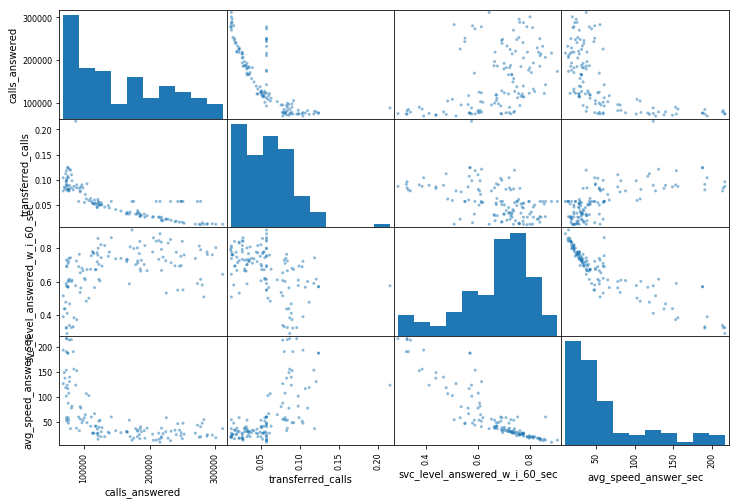

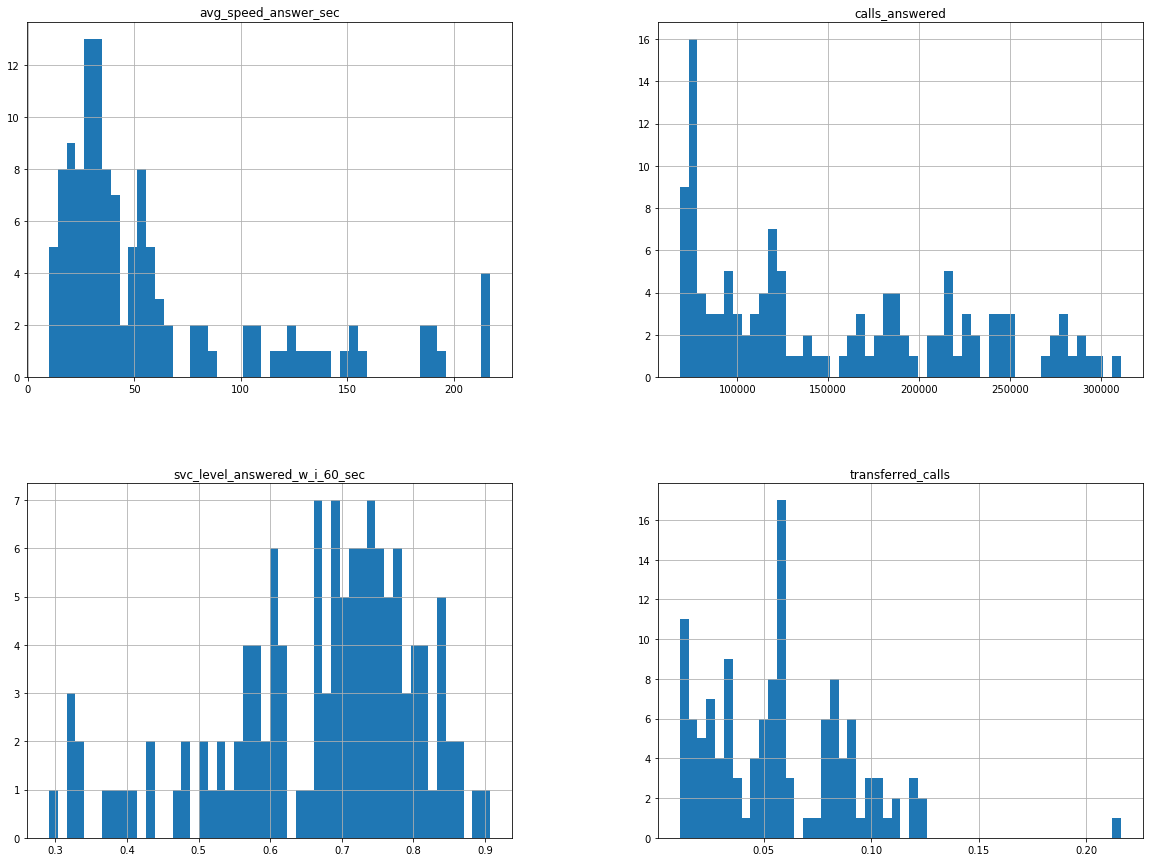

In [53]:
regr_dataset.hist(bins=50,figsize=(20,15))
plt.show()

In [49]:
attributes = ["calls_answered","transferred_calls","svc_level_answered_w_i_60_sec","avg_speed_answer_sec"]
scatter_matrix(regr_dataset[attributes],figsize=(12,8))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000194E26770B8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000194E4342B38>]], dtype=object)

The scatter matrix clearly shows relationship between avg_speed_answer_sec and calls_answered, ie as calls answered increases, the avg speed of answer reduces, and this is supported by correlation matrix

In [58]:
corr_matrix = regr_dataset.corr()
corr_matrix["calls_answered"].sort_values(ascending=False)

calls_answered                   1.000000
svc_level_answered_w_i_60_sec    0.455217
avg_speed_answer_sec            -0.605058
transferred_calls               -0.850102
Name: calls_answered, dtype: float64

The correlation matrix shows high negative correlation between the calls_answered and transferred_calls, as well 
In order to minimize transferred calls, it is important to predict the call volume accurately.
We develop Regression relation between Calls_Answered and transferred_calls, and Calls_answered with Average speed of answer and use this model to derive average speed of answer and transferred calls for next 3 months, based on Call volume predicted from above predictive model.

In [193]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_test(regr_dataset, 0.2)
print(len(train_set), "train +", len(test_set), "test")

101 train + 25 test


In [194]:
train_X = train_set.iloc[:,1] #take Calls answered as X variable
train_Y = train_set.iloc[:,4] #take Calls transferred as Y variable
test_X = test_set.iloc[:,1]
test_Y = test_set.iloc[:,4]

In [195]:
m=train_X.isnull().any()
print(m[m])
m=test_X.isnull().any()
print(m[m])


[]
[]


In [196]:
scaler1 = StandardScaler()
train_X = train_X.values.reshape(train_X.shape[0],1)
test_X = test_X.values.reshape(test_X.shape[0],1)
train_X = scaler1.fit_transform(train_X)
test_X = scaler1.transform(test_X)

C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [197]:
lin_reg = LinearRegression()
lin_reg.fit(train_X, train_Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [198]:
callTransfer_predictions = lin_reg.predict(test_X)
lin_mse = mean_squared_error(test_Y, callTransfer_predictions)
lin_rmse = np.sqrt(lin_mse)
print(lin_rmse)

0.0164974683425


In [199]:
sgd_reg = SGDRegressor(max_iter=500,penalty=None,eta0=0.1)
sgd_reg.fit(train_X, train_Y.values.ravel())

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.1,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=500, n_iter=None, penalty=None,
       power_t=0.25, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False)

In [200]:
callTransfer_predictions = sgd_reg.predict(test_X)
sgd_mse = mean_squared_error(test_Y, callTransfer_predictions)
sgd_rmse = np.sqrt(sgd_mse)
print(sgd_rmse)

0.0164716721291


We now fit Linear Regression between avg_Speed of calls answered and Call volume

In [201]:
train_Y = train_set.iloc[:,3] # take Avg speed of answer in secs as Y variable
test_Y = test_set.iloc[:,3]
train_Y = train_Y.ravel().reshape(train_Y.shape[0],1)
test_Y = test_Y.ravel().reshape(test_Y.shape[0],1)
train_X = train_X.reshape(train_X.shape[0],1)
test_X = test_X.reshape(test_X.shape[0],1)

In [149]:
lin_reg1 = LinearRegression()
lin_reg1.fit(train_X, train_Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [150]:
callAnsTime_predictions = lin_reg1.predict(test_X)
lin_mse = mean_squared_error(test_Y, callAnsTime_predictions)
lin_rmse = np.sqrt(lin_mse)
print(lin_rmse)

36.3441069579


Based on the scatter matrix we find the relation between Call answer speed and Call answered volume is not liner. Hence we try Polynomial curve fitting and expt with diff degrees. We find degree=3 gives best fit on test data

In [202]:
poly = PolynomialFeatures(degree=3)
train_X_ = poly.fit_transform(train_X)
test_X_ = poly.fit_transform(test_X)
lin_reg2 = LinearRegression()
lin_reg2.fit(train_X_, train_Y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [203]:
callAnsTime_predictions = lin_reg2.predict(test_X_)
poly_mse = mean_squared_error(test_Y, callAnsTime_predictions)
poly_rmse = np.sqrt(poly_mse)
print(poly_rmse)

40.8082136726


In [217]:
print(testX.shape)
currData = testX[7,:,:]
currData = currData.reshape(1,currData.shape[0],currData.shape[1])
print(currData.shape)
currPredict = model.predict(currData)
currPredUnscaled = np.around(scaler.inverse_transform(currPredict))
print("prediction of Call Volume at time t+1:"+str(currPredUnscaled[:,0]))
print("prediction of Call Volume at time t+2:"+str(currPredUnscaled[:,1]))
print("prediction of Call Volume at time t+3:"+str(currPredUnscaled[:,2]))

(8, 10, 1)
(1, 10, 1)
prediction of Call Volume at time t+1:[ 73748.]
prediction of Call Volume at time t+2:[ 70488.]
prediction of Call Volume at time t+3:[ 68051.]


C:\Anaconda\lib\site-packages\cntk\core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input38716") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


Now we predict Calls tranferred percentage, and Average Speed of Answer in secs for next 3 months.

In [218]:
CallVol_X = currPredUnscaled[:,:].reshape(3,1)
CallVol_X = scaler1.fit_transform(CallVol_X)
CallVol_X_ = poly.fit_transform(CallVol_X)

In [219]:
callTransf_pred = lin_reg.predict(CallVol_X)
print(callTransf_pred)
callAnsTime_pred = lin_reg2.predict(CallVol_X_)
print(callAnsTime_pred)

[ 0.0238408   0.05927616  0.08576572]
[[  35.31411587]
 [  24.58427179]
 [ 122.36054926]]


# Approach 2, We use a different Deep Learning approach to fit the Time Series data of Call Volumes, by using the stationary difference values as input to Deep Learning technique

In [19]:
from pandas import Series
n_lag = 1
n_seq = 3
n_test = 11

#use the Call volume column to create Series in pandas
series_call_volume=Series(data=dataframe.values[:,1])
print(len(series_call_volume))

# prepare data for normalization
values = series_call_volume.values
values = values.reshape((len(values), 1))


126


In [20]:
# normalize the values in a scale of 0 to 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(values)
print( ' Min: %f, Max: %f ' % (scaler.data_min_, scaler.data_max_))
# normalize the dataset and print
normalized = scaler.transform(values)


 Min: 68355.000000, Max: 311183.000000 


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [21]:
#extract values from Time Series
values_call_volume = series_call_volume.values
	
# create Time Series from the difference of x(t) and x(t-1)
diff = list()
for i in range(1, len(values_call_volume)):
	value = values_call_volume[i] - values_call_volume[i - 1]
	diff.append(value)
	
diff_series = Series(diff)

In [22]:
#prepare values for Normalization
diff_values = diff_series.values
diff_values = diff_values.reshape(len(diff_values), 1)

# Normalize values in range -1, 1 using Sklearn MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_values = scaler.fit_transform(diff_values)
scaled_values = scaled_values.reshape(len(scaled_values), 1)

C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [23]:
df = DataFrame(scaled_values)
cols = list()

#shift x values by 1 to create input sequence t-1
cols.append(df.shift(1))
    
#shift y values by 1,2,3 and create forecast sequence (t, t+1, t+2) at next 3 timesteps as y
for i in range(0, n_seq):
    cols.append(df.shift(-i))

In [24]:
#concat the values to create training dataset
agg = concat(cols, axis=1)
# drop rows with NaN values
agg.dropna(inplace=True)


In [31]:
#supervised training dataset with first column as x and next three columns as y
supervised_values = agg.values
print(supervised_values.shape)
supervised_values = supervised_values.reshape(len(supervised_values),4)

#Check the values against original data, and make sure these are indeed the difference values for the first four values in the series
print("Prepared Time series values from differences")
print(scaler.inverse_transform(supervised_values[0,0]))
print(scaler.inverse_transform(supervised_values[0,1]))
print(scaler.inverse_transform(supervised_values[0,2]))
print(scaler.inverse_transform(supervised_values[0,3]))
#print(scaler.inverse_transform(supervised_values[121,0:3]))
print("Actual call volume")
print(values[0:5,:])

(122, 4)
Prepared Time series values from differences
[[ 19245.]]
[[ 30502.]]
[[ 31408.]]
[[ 2690.]]
Actual call volume
[[91892]
 [111137]
 [141639]
 [173047]
 [175737]]


In [32]:

#use the 11 monthly values from 2017 as test data and all prev yrs as training data
train, test = supervised_values[0:-11], supervised_values[-11:]

print(train.shape)
print(test.shape)

(111, 4)
(11, 4)


In [33]:
# reshape training into [samples, timesteps, features]
X, y = train[:, 0:1], train[:, 1:] #Treat the first value as X, and the next 3 values as Y
X = X.reshape(X.shape[0], 1, X.shape[1])
print(X.shape)
print(y.shape)
X_test, y_test = test[:, 0:1], test[:, 1:]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print(X_test.shape)
print(y_test.shape)

(111, 1, 1)
(111, 3)
(11, 1, 1)
(11, 3)


In [31]:
# design network
def fit_model_stateful(n_cells):
    # define model
    model = Sequential()
    model.add(LSTM(n_cells, batch_input_shape=(1,X.shape[1],X.shape[2]),stateful=True))
    model.add(Dense(3))
    # compile model
    myOptimizer = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=0.01, decay=0.0)
    model.compile(loss='mean_squared_error', optimizer=myOptimizer)
    model.fit(X, y, epochs=1500, shuffle=False, verbose=0,batch_size=1)
    model.reset_states()
    # evaluate model
    loss = model.evaluate(X_test, y_test, verbose=0, batch_size=1)
    return loss

In [32]:

def fit_model_stateless(n_cells):
    # define model
    model = Sequential()
    model.add(LSTM(n_cells, batch_input_shape=(1,X.shape[1],X.shape[2]),stateful=False))
    model.add(Dense(3))
    # compile model
    myOptimizer = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=0.01, decay=0.0)
    model.compile(loss='mean_squared_error', optimizer=myOptimizer)
    model.fit(X, y, epochs=1500, shuffle=False, verbose=0,batch_size=1)
    # evaluate model
    loss = model.evaluate(X_test, y_test, verbose=0, batch_size=1)
    return loss


 >1/5 param=1.000000, loss=0.514470 
 >2/5 param=1.000000, loss=0.046064 
 >3/5 param=1.000000, loss=0.042042 
 >4/5 param=1.000000, loss=0.043794 
 >5/5 param=1.000000, loss=0.041865 
 >1/5 param=5.000000, loss=0.042109 
 >2/5 param=5.000000, loss=0.042341 
 >3/5 param=5.000000, loss=1.729358 
 >4/5 param=5.000000, loss=0.070479 
 >5/5 param=5.000000, loss=1.648085 
 >1/5 param=10.000000, loss=0.047736 
 >2/5 param=10.000000, loss=0.040581 
 >3/5 param=10.000000, loss=0.047498 
 >4/5 param=10.000000, loss=0.076228 
 >5/5 param=10.000000, loss=0.041913 
              1         5        10
count  5.000000  5.000000  5.000000
mean   0.137647  0.706474  0.050791
std    0.210657  0.897199  0.014580
min    0.041865  0.042109  0.040581
25%    0.042042  0.042341  0.041913
50%    0.043794  0.070479  0.047498
75%    0.046064  1.648085  0.047736
max    0.514470  1.729358  0.076228


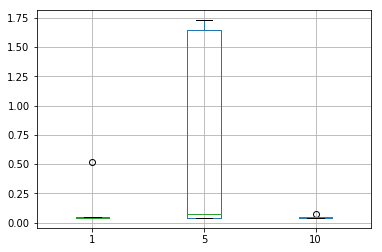

In [33]:

# define scope of search
params = [1, 5, 10]
n_repeats = 5
# grid search parameter values
scores = DataFrame()
for value in params:
# repeat each experiment multiple times
    loss_values_stateful = list()
    for i in range(n_repeats):
        loss = fit_model_stateful(value)
        loss_values_stateful.append(loss)
        print( ' >%d/%d param=%f, loss=%f ' % (i+1, n_repeats, value, loss))
# store results for this parameter
    scores[str(value)] = loss_values_stateful
# summary statistics of results
print(scores.describe())
# box and whisker plot of results
scores.boxplot()
plt.show()

We find 10 neurons in hidden layer gives best performance 

Train on 111 samples, validate on 11 samples
Epoch 1/1400
111/111 [==============================] - 2s 20ms/step - loss: 0.1481 - val_loss: 0.0440
Epoch 2/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1415 - val_loss: 0.0436
Epoch 3/1400
111/111 [==============================] - 0s 4ms/step - loss: 0.1401 - val_loss: 0.0431
Epoch 4/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1392 - val_loss: 0.0429
Epoch 5/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1387 - val_loss: 0.0428
Epoch 6/1400
111/111 [==============================] - 0s 4ms/step - loss: 0.1385 - val_loss: 0.0428
Epoch 7/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1383 - val_loss: 0.0428
Epoch 8/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1382 - val_loss: 0.0428
Epoch 9/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1381 - val_loss: 0.0428
Epoch 10/1400
111/111 [=============

111/111 [==============================] - 0s 3ms/step - loss: 0.1369 - val_loss: 0.0429
Epoch 160/1400
111/111 [==============================] - 0s 4ms/step - loss: 0.1369 - val_loss: 0.0429
Epoch 161/1400
111/111 [==============================] - 0s 4ms/step - loss: 0.1369 - val_loss: 0.0429
Epoch 162/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1369 - val_loss: 0.0429
Epoch 163/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1369 - val_loss: 0.0429
Epoch 164/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1369 - val_loss: 0.0429
Epoch 165/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1369 - val_loss: 0.0429
Epoch 166/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1369 - val_loss: 0.0428
Epoch 167/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1368 - val_loss: 0.0428
Epoch 168/1400
111/111 [==============================] - 0s 2ms/step - loss: 0

Epoch 238/1400
111/111 [==============================] - 0s 4ms/step - loss: 0.1357 - val_loss: 0.0422
Epoch 239/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1357 - val_loss: 0.0422
Epoch 240/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1357 - val_loss: 0.0421
Epoch 241/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1357 - val_loss: 0.0421
Epoch 242/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1357 - val_loss: 0.0421
Epoch 243/1400
111/111 [==============================] - 0s 4ms/step - loss: 0.1356 - val_loss: 0.0421
Epoch 244/1400
111/111 [==============================] - 1s 5ms/step - loss: 0.1356 - val_loss: 0.0421
Epoch 245/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1356 - val_loss: 0.0421
Epoch 246/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1356 - val_loss: 0.0421
Epoch 247/1400
111/111 [==============================] - 0s 4ms

Epoch 317/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1338 - val_loss: 0.0412
Epoch 318/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1338 - val_loss: 0.0412
Epoch 319/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1338 - val_loss: 0.0412
Epoch 320/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1338 - val_loss: 0.0412
Epoch 321/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1338 - val_loss: 0.0412
Epoch 322/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1337 - val_loss: 0.0411
Epoch 323/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1337 - val_loss: 0.0411
Epoch 324/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1337 - val_loss: 0.0411
Epoch 325/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1337 - val_loss: 0.0411
Epoch 326/1400
111/111 [==============================] - 0s 2ms

C:\Anaconda\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109000). Check your callbacks.
  % delta_t_median)


111/111 [==============================] - 1s 7ms/step - loss: 0.1333 - val_loss: 0.0409
Epoch 345/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1332 - val_loss: 0.0409
Epoch 346/1400
111/111 [==============================] - 1s 6ms/step - loss: 0.1332 - val_loss: 0.0409
Epoch 347/1400
111/111 [==============================] - 1s 6ms/step - loss: 0.1332 - val_loss: 0.0409
Epoch 348/1400
111/111 [==============================] - 0s 4ms/step - loss: 0.1332 - val_loss: 0.0409
Epoch 349/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1332 - val_loss: 0.0408
Epoch 350/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1331 - val_loss: 0.0408
Epoch 351/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1331 - val_loss: 0.0408
Epoch 352/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1331 - val_loss: 0.0408
Epoch 353/1400
111/111 [==============================] - 0s 2ms/step - loss: 0

Epoch 501/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1302 - val_loss: 0.0379
Epoch 502/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1302 - val_loss: 0.0379
Epoch 503/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1302 - val_loss: 0.0378
Epoch 504/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1302 - val_loss: 0.0378
Epoch 505/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1302 - val_loss: 0.0378
Epoch 506/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1302 - val_loss: 0.0378
Epoch 507/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1302 - val_loss: 0.0377
Epoch 508/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1302 - val_loss: 0.0377
Epoch 509/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1302 - val_loss: 0.0377
Epoch 510/1400
111/111 [==============================] - 0s 2ms

Epoch 580/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1298 - val_loss: 0.0365
Epoch 581/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1299 - val_loss: 0.0365
Epoch 582/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1299 - val_loss: 0.0365
Epoch 583/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1298 - val_loss: 0.0365
Epoch 584/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1298 - val_loss: 0.0365
Epoch 585/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1298 - val_loss: 0.0364
Epoch 586/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1298 - val_loss: 0.0364
Epoch 587/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1298 - val_loss: 0.0364
Epoch 588/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1298 - val_loss: 0.0364
Epoch 589/1400
111/111 [==============================] - 0s 2ms

Epoch 659/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1296 - val_loss: 0.0358
Epoch 660/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1296 - val_loss: 0.0358
Epoch 661/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1296 - val_loss: 0.0358
Epoch 662/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1296 - val_loss: 0.0358
Epoch 663/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1296 - val_loss: 0.0358
Epoch 664/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1296 - val_loss: 0.0357
Epoch 665/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1296 - val_loss: 0.0357
Epoch 666/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1296 - val_loss: 0.0357
Epoch 667/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1296 - val_loss: 0.0357
Epoch 668/1400
111/111 [==============================] - 0s 2ms

111/111 [==============================] - 0s 2ms/step - loss: 0.1293 - val_loss: 0.0351
Epoch 816/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1293 - val_loss: 0.0351
Epoch 817/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1293 - val_loss: 0.0351
Epoch 818/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1293 - val_loss: 0.0351
Epoch 819/1400
111/111 [==============================] - 0s 4ms/step - loss: 0.1293 - val_loss: 0.0351
Epoch 820/1400
111/111 [==============================] - 0s 4ms/step - loss: 0.1293 - val_loss: 0.0351
Epoch 821/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1293 - val_loss: 0.0351
Epoch 822/1400
111/111 [==============================] - 1s 5ms/step - loss: 0.1293 - val_loss: 0.0351
Epoch 823/1400
111/111 [==============================] - 1s 6ms/step - loss: 0.1293 - val_loss: 0.0351
Epoch 824/1400
111/111 [==============================] - 0s 3ms/step - loss: 0

Epoch 894/1400
111/111 [==============================] - 0s 4ms/step - loss: 0.1291 - val_loss: 0.0349
Epoch 895/1400
111/111 [==============================] - 0s 4ms/step - loss: 0.1291 - val_loss: 0.0349
Epoch 896/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1291 - val_loss: 0.0349
Epoch 897/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1291 - val_loss: 0.0349
Epoch 898/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1291 - val_loss: 0.0349
Epoch 899/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1291 - val_loss: 0.0349
Epoch 900/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1291 - val_loss: 0.0349
Epoch 901/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1291 - val_loss: 0.0349
Epoch 902/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1291 - val_loss: 0.0349
Epoch 903/1400
111/111 [==============================] - 0s 2ms

Epoch 973/1400
111/111 [==============================] - 0s 4ms/step - loss: 0.1290 - val_loss: 0.0348
Epoch 974/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1290 - val_loss: 0.0348
Epoch 975/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1290 - val_loss: 0.0348
Epoch 976/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1290 - val_loss: 0.0348
Epoch 977/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1290 - val_loss: 0.0348
Epoch 978/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1290 - val_loss: 0.0348
Epoch 979/1400
111/111 [==============================] - 0s 4ms/step - loss: 0.1290 - val_loss: 0.0348
Epoch 980/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1290 - val_loss: 0.0348
Epoch 981/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1290 - val_loss: 0.0348
Epoch 982/1400
111/111 [==============================] - 0s 3ms

111/111 [==============================] - 0s 3ms/step - loss: 0.1288 - val_loss: 0.0346
Epoch 1130/1400
111/111 [==============================] - 0s 4ms/step - loss: 0.1288 - val_loss: 0.0346
Epoch 1131/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1288 - val_loss: 0.0346
Epoch 1132/1400
111/111 [==============================] - 0s 4ms/step - loss: 0.1287 - val_loss: 0.0346
Epoch 1133/1400
111/111 [==============================] - 0s 4ms/step - loss: 0.1287 - val_loss: 0.0346
Epoch 1134/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1287 - val_loss: 0.0346
Epoch 1135/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1287 - val_loss: 0.0346
Epoch 1136/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1287 - val_loss: 0.0346
Epoch 1137/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1287 - val_loss: 0.0346
Epoch 1138/1400
111/111 [==============================] - 0s 3ms/step 

111/111 [==============================] - 0s 3ms/step - loss: 0.1284 - val_loss: 0.0345
Epoch 1285/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1285 - val_loss: 0.0345
Epoch 1286/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1284 - val_loss: 0.0345
Epoch 1287/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1284 - val_loss: 0.0345
Epoch 1288/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1284 - val_loss: 0.0345
Epoch 1289/1400
111/111 [==============================] - 0s 3ms/step - loss: 0.1284 - val_loss: 0.0345
Epoch 1290/1400
111/111 [==============================] - 0s 4ms/step - loss: 0.1284 - val_loss: 0.0345
Epoch 1291/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1284 - val_loss: 0.0345
Epoch 1292/1400
111/111 [==============================] - 0s 2ms/step - loss: 0.1284 - val_loss: 0.0345
Epoch 1293/1400
111/111 [==============================] - 0s 4ms/step 

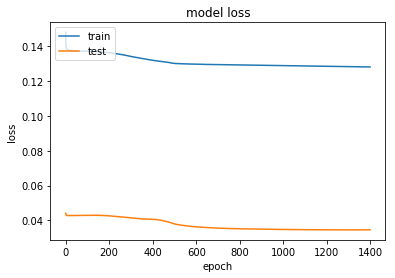

In [34]:
#Based on error plot, choose 5 neurons in intermediate layer
model = Sequential()
model.add(LSTM(10, batch_input_shape=(1, 1, 1), stateful=False))
model.add(Dense(3))
myOptimizer = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=0.01, decay=0.0)
model.compile(loss='mean_squared_error', optimizer=myOptimizer)
history = model.fit(X, y, epochs=1400, validation_data=(X_test,y_test), batch_size=1, verbose=1, shuffle=False)
loss = model.evaluate(X_test,y_test,batch_size=1,verbose=0)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [35]:
#Save the model
model.save('C:/users/hackuser1/lstm_time_series_stless.h5')

#Load model
#model = load_model('C:/users/hackuser1/lstm_time_series_stless.h5')

In [36]:
# make forecast
forecasts = list()
	
for i in range(len(test)):
    X_test_inp = X_test[i,0,0]
    X_test_inp = X_test_inp.reshape(1,1,1)
    forecast = model.predict(X_test_inp, batch_size=1)
    forecasts.append(forecast)
    
print(forecasts)

[array([[-0.10767417, -0.1920864 , -0.23942053]], dtype=float32), array([[-0.15367219, -0.18177706, -0.08998713]], dtype=float32), array([[-0.09960766, -0.19542798, -0.2835747 ]], dtype=float32), array([[-0.19831343, -0.18253753, -0.09714389]], dtype=float32), array([[-0.47409001, -0.05098829, -0.16723399]], dtype=float32), array([[-0.11316969, -0.19346721, -0.27819183]], dtype=float32), array([[-0.28970632, -0.16052581, -0.13368607]], dtype=float32), array([[-0.10513038, -0.1932331 , -0.25337875]], dtype=float32), array([[-0.22214893, -0.17947021, -0.10843343]], dtype=float32), array([[-0.15215982, -0.1817058 , -0.09112343]], dtype=float32), array([[-0.17823154, -0.18308119, -0.08862606]], dtype=float32)]


In [37]:
# invert difference values to have absolute value
def inverse_difference(last_ob, unscaled_diff):
	inverted = list()
	inverted.append(last_ob+unscaled_diff[0])
	for i in range(1, len(unscaled_diff)):
		inverted.append(inverted[i-1]+unscaled_diff[i])
	return inverted

inverted = list()
for i in range(len(forecasts)):
	# create array from forecast
	forecast = np.array(forecasts[i])
    #the 3 step values of call volume into the future
	forecast = forecast.reshape(1, 3)
	# invert scaling
	inv_scale = scaler.inverse_transform(forecast)
	inv_scale = inv_scale[0, :]

	index = len(series_call_volume) - (n_test+2) + i - 1
	last_ob = series_call_volume.values[index]
    
    #get actual value of call volume based on forecast difference, and actual
	inv_diff = inverse_difference(last_ob, inv_scale)
	inverted.append(inv_diff)

inverted = np.around(inverted, decimals=0)

forecasts_inv = inverted
print(forecasts_inv)

[[ 82672.  80720.  77165.]
 [ 80268.  78665.  80172.]
 [ 75210.  73144.  68094.]
 [ 74101.  72473.  73737.]
 [ 77103.  79930.  78820.]
 [ 74194.  72195.  67327.]
 [ 74151.  73269.  73295.]
 [ 74420.  72430.  68402.]
 [ 73877.  72352.  73234.]
 [ 75270.  73670.  75138.]
 [ 75409.  73762.  75315.]]


In [38]:
#get actual values of Call volume for the 3 time steps, by taking from index=n_lag onwards
actuals = [row[n_lag:] for row in test]
print(test)
print(actuals)

[[-0.3004945  -0.15943612 -0.33786995 -0.06847738]
 [-0.15943612 -0.33786995 -0.06847738  0.22993579]
 [-0.33786995 -0.06847738  0.22993579 -0.58125323]
 [-0.06847738  0.22993579 -0.58125323  0.04081482]
 [ 0.22993579 -0.58125323  0.04081482 -0.31109307]
 [-0.58125323  0.04081482 -0.31109307 -0.03349325]
 [ 0.04081482 -0.31109307 -0.03349325 -0.16330356]
 [-0.31109307 -0.03349325 -0.16330356 -0.10428814]
 [-0.03349325 -0.16330356 -0.10428814 -0.1622998 ]
 [-0.16330356 -0.10428814 -0.1622998  -0.35531774]
 [-0.10428814 -0.1622998  -0.35531774 -0.00078235]]
[array([-0.15943612, -0.33786995, -0.06847738]), array([-0.33786995, -0.06847738,  0.22993579]), array([-0.06847738,  0.22993579, -0.58125323]), array([ 0.22993579, -0.58125323,  0.04081482]), array([-0.58125323,  0.04081482, -0.31109307]), array([ 0.04081482, -0.31109307, -0.03349325]), array([-0.31109307, -0.03349325, -0.16330356]), array([-0.03349325, -0.16330356, -0.10428814]), array([-0.16330356, -0.10428814, -0.1622998 ]), array

In [39]:
# invert scaling of actual values and get actual call volume from difference
inverted = list()
for i in range(len(actuals)):
	actual = np.array(actuals[i])
	actual = actual.reshape(1, 3)

	inv_scale = scaler.inverse_transform(actual)
	inv_scale = inv_scale[0, :]

	index = len(series_call_volume) - (n_test+2) + i - 1
	last_ob = series_call_volume.values[index]
	inv_diff = inverse_difference(last_ob, inv_scale)

	inverted.append(inv_diff)

inverted = np.around(inverted, decimals=0)

actuals_inv = inverted
print(actuals_inv)

[[ 80919.  74029.  76264.]
 [ 74029.  76264.  88607.]
 [ 76264.  88607.  73473.]
 [ 88607.  73473.  79410.]
 [ 73473.  79410.  73427.]
 [ 79410.  73427.  76847.]
 [ 73427.  76847.  75870.]
 [ 76847.  75870.  76892.]
 [ 75870.  76892.  75949.]
 [ 76892.  75949.  68468.]
 [ 75949.  68468.  72996.]]


In [42]:
# evaluate the RMSE for each forecast time step
def evaluate_forecasts(actuals, forecasts, n_lag, n_seq):
	for i in range(n_seq):
		actual = [row[i] for row in actuals]
		predicted = [forecast[i] for forecast in forecasts]
		rmse = sqrt(mean_squared_error(actual, predicted))
		print('t+%d RMSE: %f' % ((i+1), rmse))

In [43]:
# evaluate forecasts
print(len(actuals_inv))
evaluate_forecasts(actuals_inv, forecasts_inv, n_lag, n_seq)

11
t+1 RMSE: 5284.846914
t+2 RMSE: 5806.692346
t+3 RMSE: 5944.753653


(11, 3)


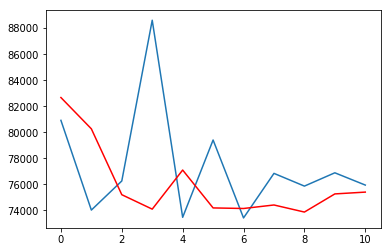

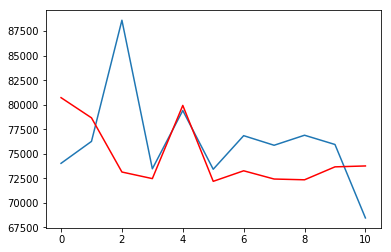

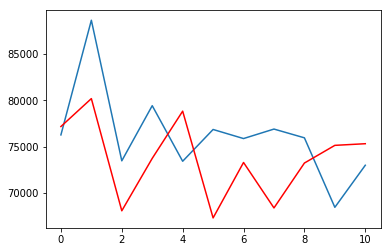

In [45]:
# plot forecastss
print(actuals_inv.shape)
plt.plot(actuals_inv[:,0])
plt.plot(forecasts_inv[:,0],color='red')
pyplot.legend(['Actual','Predicted'])
pyplot.title('Actual vs Predicted at time t+1')
plt.show()

plt.plot(actuals_inv[:,1])
plt.plot(forecasts_inv[:,1],color='red')
pyplot.legend(['Actual','Predicted'])
pyplot.title('Actual vs Predicted at time t+2')
plt.show()

plt.plot(actuals_inv[:,2])
plt.plot(forecasts_inv[:,2],color='red')
pyplot.legend(['Actual','Predicted'])
pyplot.title('Actual vs Predicted at time t+3')
plt.show()


We find both approaches of Time Series forecasting using Lookback values and stationary difference values using LSTM cells in a Deep Learning model, give comparable results. Hence we decide to use the simpler model with lookback values.